In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix
from datetime import datetime

In [ ]:
pip install pyclustering


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=ba62be251e2b8381af316eeae5f8b7adef2ca25cbb730d630274a0d33bf816dd
  Stored in directory: /root/.cache/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


In [ ]:
df = pd.read_csv("data_gabung_final.csv")
df.head()

,no_invoice,tanggal,nama_customer,nama_barang,qty,harga,total_harga,diskon
0,INV-21A00001,2021-04-01,CV.M3 CAKRAWALA,KASUR EKONOMI 12 X 90 X 200,30,"255,000","7,650,000",0
1,INV-21A00001,2021-04-01,CV.M3 CAKRAWALA,KASUR EKONOMI 12 X 140 X 200,30,"371,000","11,130,000",0
2,INV-21A00001,2021-04-01,CV.M3 CAKRAWALA,KASUR EKONOMI 12 X 120 X 200,30,"339,500","10,185,000",0
3,INV-21A00001,2021-04-01,CV.M3 CAKRAWALA,BANTAL BUSA,45,1,45,45
4,INV-21A00001,2021-04-01,CV.M3 CAKRAWALA,GULING BUSA,45,1,45,45


In [ ]:
df["tanggal"] = pd.to_datetime(df["tanggal"], format='mixed')
df["qty"] = df["qty"].str.replace(',', '').astype(int)
df["harga"] = df["harga"].str.replace(',', '').astype(float)
df["total_harga"] = df["total_harga"].str.replace(',', '').astype(float)
df["diskon"] = pd.to_numeric(df["diskon"].str.replace(',', ''), errors='coerce').fillna(0)

In [ ]:
df['nama_customer'].nunique()

216

In [ ]:
today = df["tanggal"].max()

LRFM

In [ ]:
# Calculate LRFM metrics
customer_lrfm = df.groupby("nama_customer").agg(
    Length=("tanggal", lambda x: (x.max() - x.min()).days),  # L: Duration of relationship
    Recency=("tanggal", lambda x: (today - x.max()).days),   # R: Days since last purchase
    Frequency=("no_invoice", "count"),                        # F: Number of purchases
    Monetary=("total_harga", "sum")                               # M: Total spending
).reset_index()

In [ ]:
customer_lrfm.head()

,nama_customer,Length,Recency,Frequency,Monetary
0,7 JAYA,890,45,2,27901400.0
1,ANTO,678,47,130,214184251.0
2,BELU ONE,322,246,14,23841000.0
3,BERKAT UTAMA,1010,47,60,74344290.0
4,BINA MAKMUR,0,30,1,360364.0


In [ ]:
customer_lrfm.describe()

,Length,Recency,Frequency,Monetary
count,307.000000,307.000000,307.000000,3.070000e+02
mean,367.117264,316.654723,29.964169,5.799078e+07
std,403.963928,303.807566,74.717389,1.428485e+08
min,0.000000,0.000000,1.000000,6.500000e+04
25%,0.000000,58.000000,2.000000,2.190610e+06
50%,179.000000,204.000000,6.000000,6.882504e+06
75%,783.000000,509.000000,17.500000,3.414217e+07
max,1089.000000,1075.000000,577.000000,1.134740e+09


In [ ]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(customer_lrfm.iloc[:, 1:])

lrfm_scaled_df = pd.DataFrame(scaled_values, columns=['Length', 'Recency', 'Frequency', 'Monetary'])
lrfm_scaled_df.insert(0, 'nama_customer', customer_lrfm['nama_customer'])

In [ ]:
lrfm_scaled_df.head()

,nama_customer,Length,Recency,Frequency,Monetary
0,7 JAYA,0.817264,0.041860,0.001736,0.024532
1,ANTO,0.622590,0.043721,0.223958,0.188705
2,BELU ONE,0.295684,0.228837,0.022569,0.020954
3,BERKAT UTAMA,0.927456,0.043721,0.102431,0.065463
4,BINA MAKMUR,0.000000,0.027907,0.000000,0.000260


In [ ]:
lrfm_scaled_df.describe()

,Length,Recency,Frequency,Monetary
count,307.000000,307.000000,307.000000,307.000000
mean,0.337114,0.294563,0.050285,0.051051
std,0.370949,0.282612,0.129718,0.125894
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.053953,0.001736,0.001873
50%,0.164371,0.189767,0.008681,0.006008
75%,0.719008,0.473488,0.028646,0.030033
max,1.000000,1.000000,1.000000,1.000000


Plot Distribution

<ipython-input-11-3f95252ffd13>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Feature')


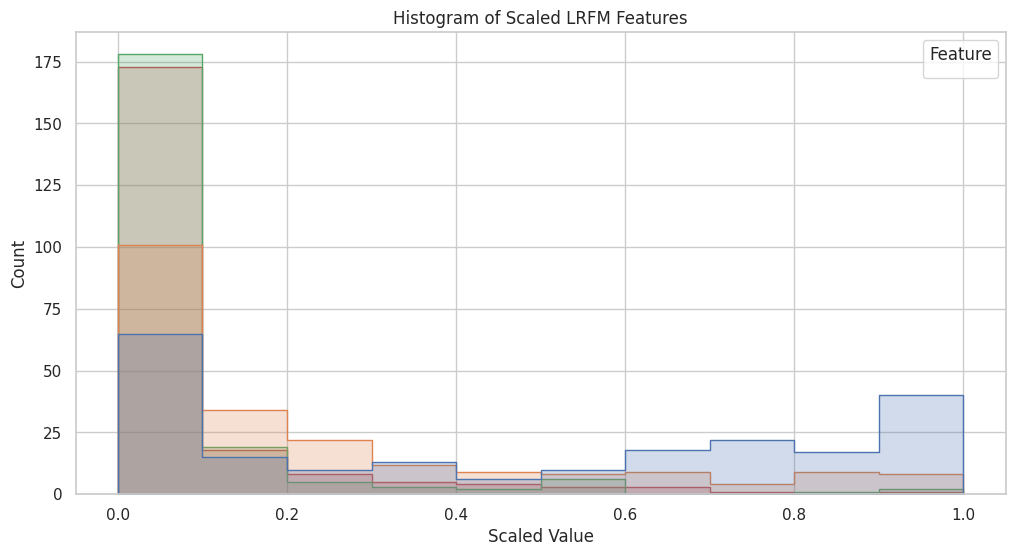

In [ ]:
# style
sns.set(style='whitegrid')

# Plot histogram for each feature
lrfm_melted = lrfm_scaled_df.melt(id_vars='nama_customer', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.histplot(data=lrfm_melted, x='Value', hue='Feature', element='step', common_norm=False, bins=10)
plt.title('Histogram of Scaled LRFM Features')
plt.xlabel('Scaled Value')
plt.ylabel('Count')
plt.legend(title='Feature')
plt.show()

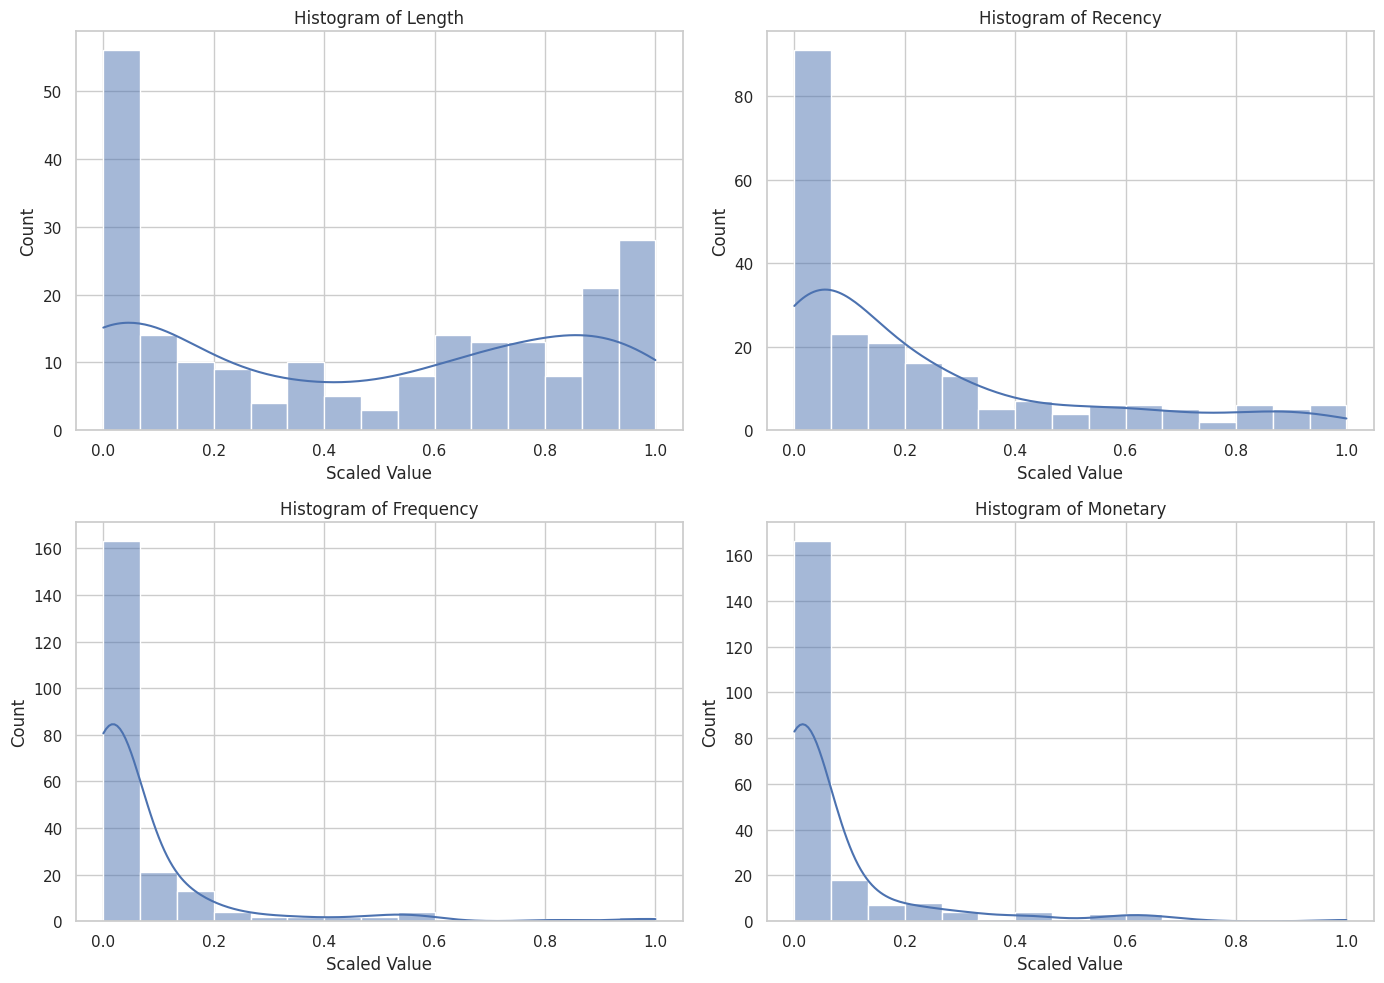

In [ ]:
features = ['Length', 'Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(14, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(lrfm_scaled_df[feature], bins=15, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

yeon johnson transformation

In [ ]:
#yeo johnson transformation
customer_lrfm_log = customer_lrfm.copy()
#columns to transform
cols_to_transform = ['Length','Recency', 'Frequency', 'Monetary']
pt = PowerTransformer(method='yeo-johnson')
customer_lrfm_log[cols_to_transform] = pt.fit_transform(customer_lrfm_log[cols_to_transform])
#cols to scale
cols_to_scale = ['Length', 'Recency', 'Frequency', 'Monetary']
lrfm_scaled = scaler.fit_transform(customer_lrfm_log[cols_to_scale])

# Create final DataFrame
lrfm_scaled_df_2 = pd.DataFrame(lrfm_scaled, columns=cols_to_scale)
lrfm_scaled_df_2.insert(0, 'nama_customer', customer_lrfm['nama_customer'])

# Preview
lrfm_scaled_df_2.head()

,nama_customer,Length,Recency,Frequency,Monetary
0,7 JAYA,0.960014,0.300407,0.156605,0.656638
1,ANTO,0.907409,0.306086,0.894969,0.850491
2,BELU ONE,0.770846,0.590945,0.594079,0.641152
3,BERKAT UTAMA,0.984979,0.306086,0.814450,0.751418
4,BINA MAKMUR,0.000000,0.251093,0.000000,0.198508


In [ ]:
lrfm_scaled_df_2.describe()

,Length,Recency,Frequency,Monetary
count,307.000000,307.000000,307.000000,307.000000
mean,0.504923,0.550455,0.396351,0.531341
std,0.430581,0.265047,0.306296,0.208066
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.334162,0.156605,0.396320
50%,0.670466,0.550971,0.418286,0.516052
75%,0.935062,0.769802,0.634442,0.676401
max,1.000000,1.000000,1.000000,1.000000


<ipython-input-53-2c1480017698>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Feature')


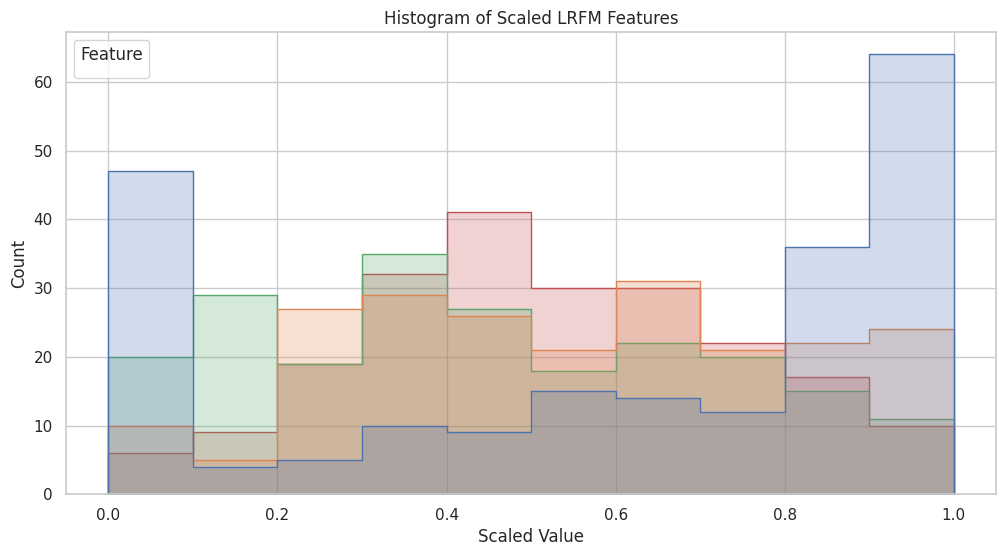

In [ ]:
# Set style
sns.set(style='whitegrid')

# Plot histogram for each feature
lrfm_melted = lrfm_scaled_df_2.melt(id_vars='nama_customer', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.histplot(data=lrfm_melted, x='Value', hue='Feature', element='step', common_norm=False, bins=10)
plt.title('Histogram of Scaled LRFM Features')
plt.xlabel('Scaled Value')
plt.ylabel('Count')
plt.legend(title='Feature')
plt.show()

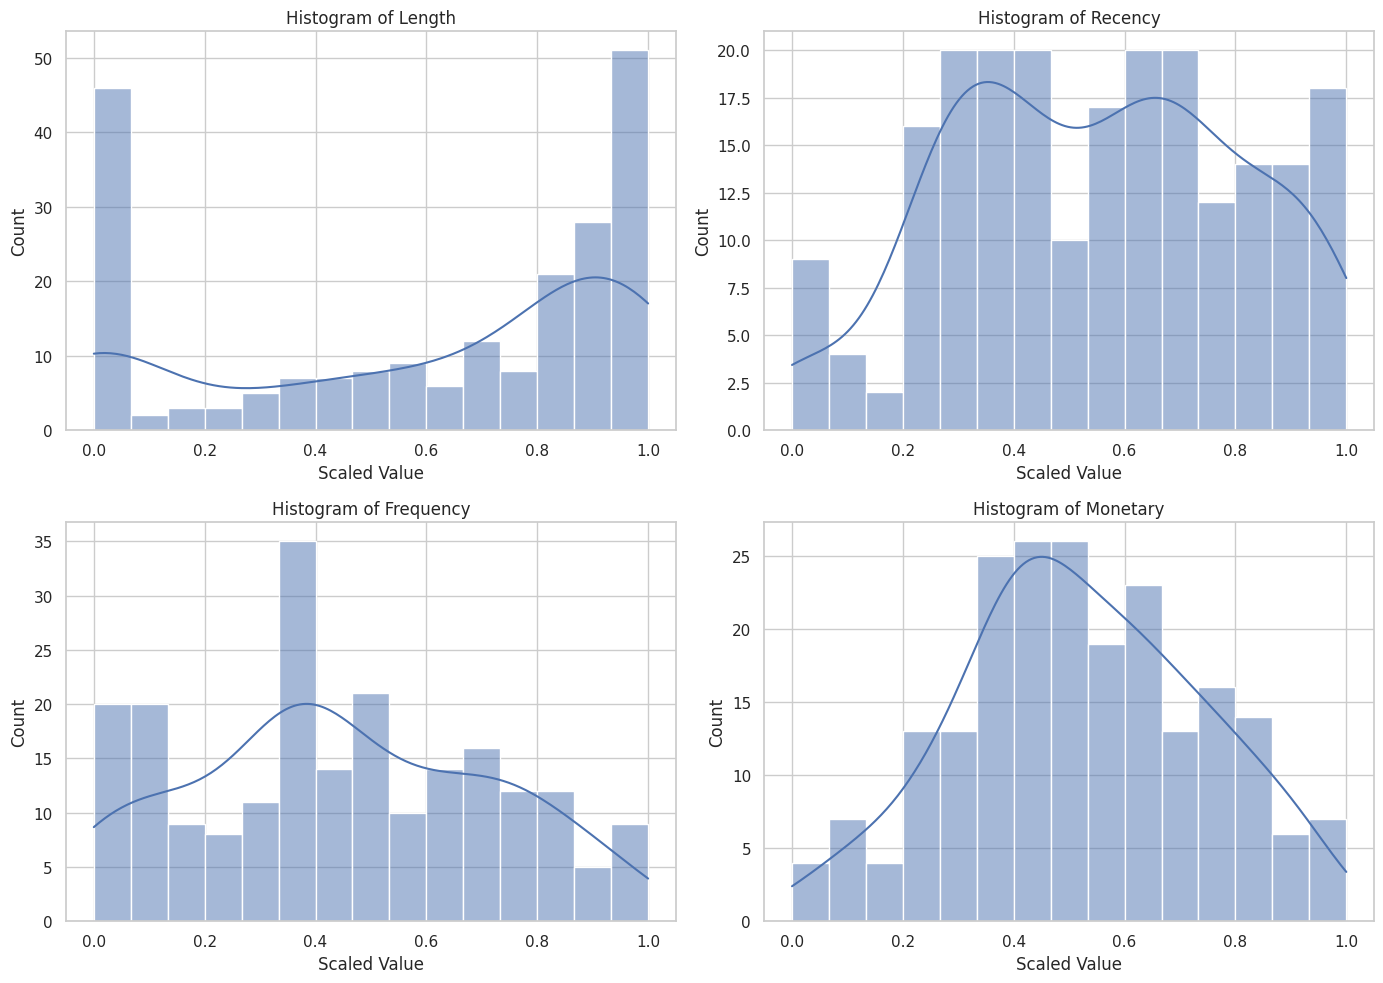

In [ ]:
features = ['Length', 'Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(14, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(lrfm_scaled_df_2[feature], bins=15, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Normalisasi

In [ ]:
import pandas as pd

# Define bins and labels
bins = [-0.01, 0.10, 0.30, 0.50, 0.70, 1.00]
labels = [5, 4, 3, 2, 1]

# Apply categorization to each column you want, e.g. all your scaled columns
for col in ['Length', 'Recency', 'Frequency', 'Monetary']:
    lrfm_scaled_df_2[col + '_norm'] = pd.cut(lrfm_scaled_df_2[col], bins=bins, labels=labels)

# Check the result
print(lrfm_scaled_df_2.head())

  nama_customer    Length   Recency  Frequency  Monetary Length_norm  \
0        7 JAYA  0.897596  0.398354   0.117811  0.580246           1   
1          ANTO  0.798426  0.404459   0.840901  0.804431           1   
2      BELU ONE  0.503776  0.677712   0.497221  0.563598           2   
3  BERKAT UTAMA  0.962120  0.404459   0.737239  0.686064           1   
4   BINA MAKMUR  0.000000  0.343869   0.000000  0.151755           5   

  Recency_norm Frequency_norm Monetary_norm  
0            3              4             2  
1            3              1             1  
2            2              3             2  
3            3              1             2  
4            3              5             4  


In [ ]:
#normalized df
final_df_LRFM = lrfm_scaled_df_2[['nama_customer', 'Length_norm', 'Recency_norm', 'Frequency_norm', 'Monetary_norm']].copy()

# Show the new DataFrame
print(final_df_LRFM.head())


  nama_customer Length_norm Recency_norm Frequency_norm Monetary_norm
0        7 JAYA           1            3              4             2
1          ANTO           1            3              1             1
2      BELU ONE           2            2              3             2
3  BERKAT UTAMA           1            3              1             2
4   BINA MAKMUR           5            3              5             4


MLRFM

In [ ]:
import pandas as pd
from functools import reduce

# Reference max date
max_date = df['tanggal'].max()

# Calculate overall Recency
recency_df = df.groupby('nama_customer')['tanggal'].max().reset_index()
recency_df['Recency'] = (max_date - recency_df['tanggal']).dt.days
recency_df = recency_df[['nama_customer', 'Recency']]

# Period definitions
periods = {'365d': 365, '730d': 730, '1095d': 1095}
rfm_list = []

for label, days in periods.items():
    start_date = max_date - pd.Timedelta(days=days)
    df_period = df[df['tanggal'] > start_date]

    # Frequency = unique invoice count
    frequency = df_period.groupby('nama_customer')['no_invoice'].nunique().reset_index()
    # Monetary = sum of total_harga
    monetary = df_period.groupby('nama_customer')['total_harga'].sum().reset_index()

    rfm = frequency.merge(monetary, on='nama_customer', how='outer')
    rfm = rfm.rename(columns={
        'no_invoice': f'Frequency_{label}',
        'total_harga': f'Monetary_{label}'
    })

    rfm_list.append(rfm)

# Merge all periods into one wide-format table
mlrfm = reduce(lambda left, right: pd.merge(left, right, on='nama_customer', how='outer'), rfm_list)

# Merge with Recency
final_mlrfm = recency_df.merge(mlrfm, on='nama_customer', how='outer')

# Optional: Fill missing values
final_mlrfm.fillna({
    'Frequency_365d': 0, 'Monetary_365d': 0,
    'Frequency_730d': 0, 'Monetary_730d': 0,
    'Frequency_1095d': 0, 'Monetary_1095d': 0,
    'Recency': 999
}, inplace=True)

# Preview
print(final_mlrfm.head())

  nama_customer  Recency  Frequency_365d  Monetary_365d  Frequency_730d  \
0        7 JAYA       45             1.0     26216400.0             1.0   
1          ANTO       47            11.0    126888012.0            41.0   
2      BELU ONE      246             3.0     16049000.0             9.0   
3  BERKAT UTAMA       47            11.0     48747995.0            17.0   
4   BINA MAKMUR       30             1.0       360364.0             1.0   

   Monetary_730d  Frequency_1095d  Monetary_1095d  
0     26216400.0                2      27901400.0  
1    214184251.0               41     214184251.0  
2     23841000.0                9      23841000.0  
3     64374275.0               22      74344290.0  
4       360364.0                1        360364.0  


minmax

In [ ]:
scaled_values = scaler.fit_transform(final_mlrfm.iloc[:, 1:])

mlrfm_scaled_df = pd.DataFrame(scaled_values, columns=['Recency', 'Frequency_365d', 'Monetary_365d', 'Frequency_730d', 'Monetary_730d', 'Frequency_1095d', 'Monetary_1095d'])
mlrfm_scaled_df.insert(0, 'nama_customer', final_mlrfm['nama_customer'])

In [ ]:
mlrfm_scaled_df.head()

,nama_customer,Recency,Frequency_365d,Monetary_365d,Frequency_730d,Monetary_730d,Frequency_1095d,Monetary_1095d
0,7 JAYA,0.041860,0.004739,0.069800,0.004367,0.039810,0.004219,0.024532
1,ANTO,0.043721,0.052133,0.337833,0.179039,0.325240,0.168776,0.188705
2,BELU ONE,0.228837,0.014218,0.042730,0.039301,0.036203,0.033755,0.020954
3,BERKAT UTAMA,0.043721,0.052133,0.129789,0.074236,0.097753,0.088608,0.065463
4,BINA MAKMUR,0.027907,0.004739,0.000959,0.004367,0.000547,0.000000,0.000260


plot

<ipython-input-37-f3eedd5ff8f0>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Feature')


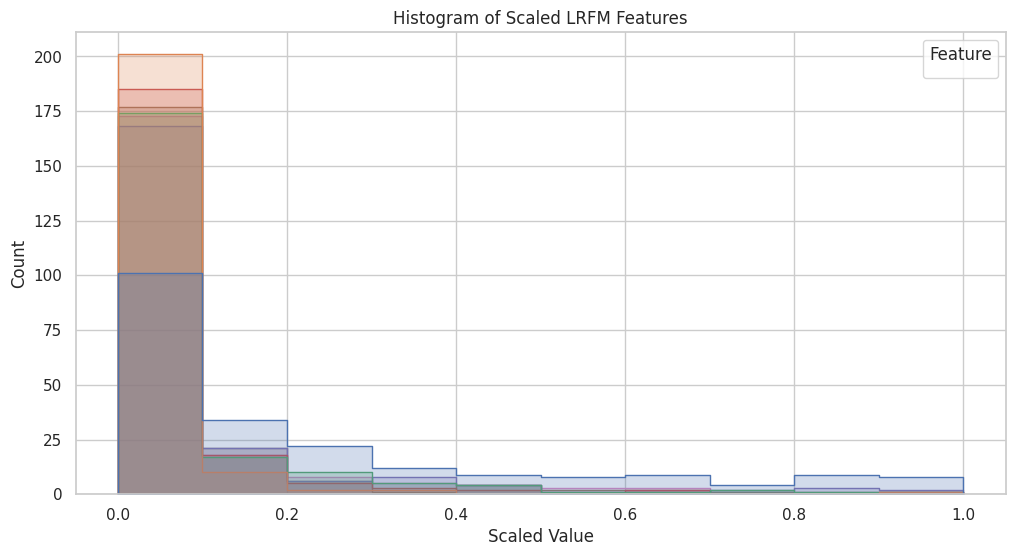

In [ ]:
# style
sns.set(style='whitegrid')

# Plot histogram for each feature
mlrfm_melted = mlrfm_scaled_df.melt(id_vars='nama_customer', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.histplot(data=mlrfm_melted, x='Value', hue='Feature', element='step', common_norm=False, bins=10)
plt.title('Histogram of Scaled MLRFM Features')
plt.xlabel('Scaled Value')
plt.ylabel('Count')
plt.legend(title='Feature')
plt.show()

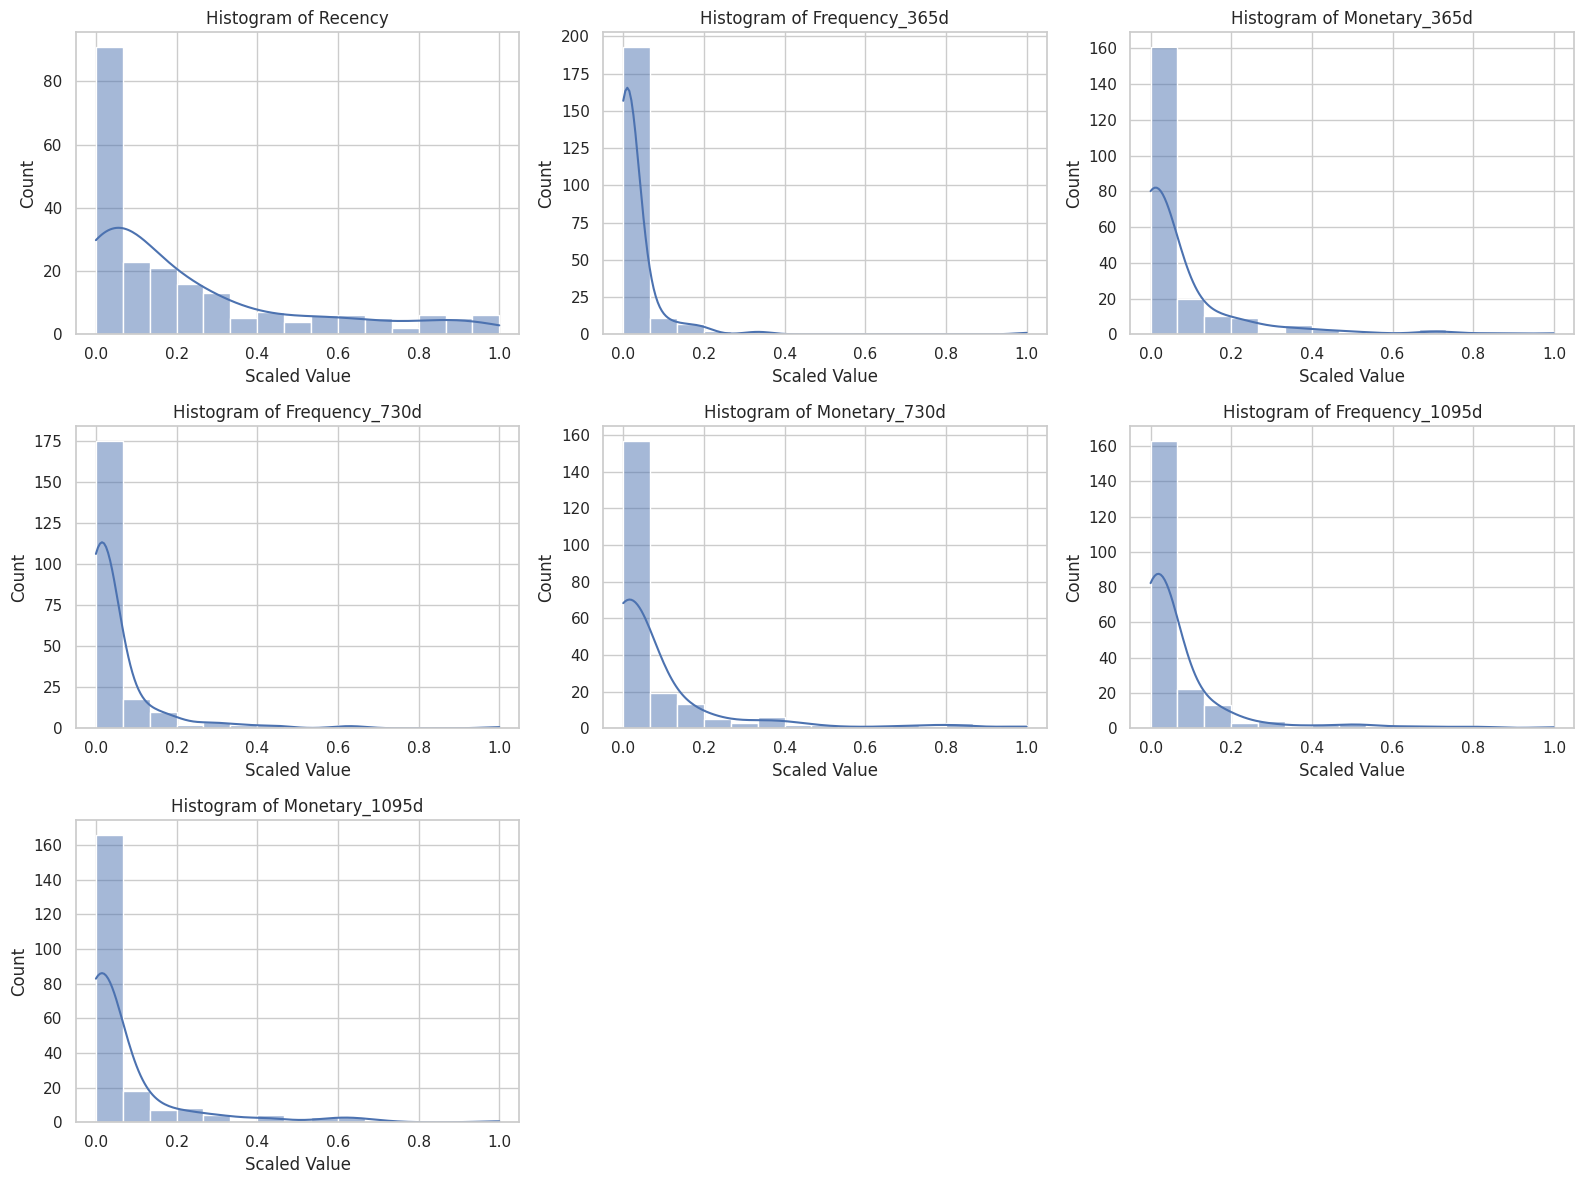

In [ ]:
mlrfm_features = ['Recency', 'Frequency_365d', 'Monetary_365d', 'Frequency_730d', 'Monetary_730d', 'Frequency_1095d', 'Monetary_1095d']

plt.figure(figsize=(16, 12))

for i, feature in enumerate(mlrfm_features, 1):
    plt.subplot(3, 3, i)  # enough room for 7 plots
    sns.histplot(mlrfm_scaled_df[feature], bins=15, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# Create combined Frequency column
mlrfm_scaled_df['Multi_Layer_Frequency'] = (
    0.5 * mlrfm_scaled_df['Frequency_365d'] +
    0.3 * mlrfm_scaled_df['Frequency_730d'] +
    0.2 * mlrfm_scaled_df['Frequency_1095d']
)

# Create combined Monetary column
mlrfm_scaled_df['Multi_Layer_Monetary'] = (
    0.5 * mlrfm_scaled_df['Monetary_365d'] +
    0.3 * mlrfm_scaled_df['Monetary_730d'] +
    0.2 * mlrfm_scaled_df['Monetary_1095d']
)

# Check the new columns
print(mlrfm_scaled_df[['nama_customer','Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']].head())

  nama_customer   Recency  Multi_Layer_Frequency  Multi_Layer_Monetary
0        7 JAYA  0.041860               0.004524              0.051749
1          ANTO  0.043721               0.113533              0.304230
2      BELU ONE  0.228837               0.025650              0.036416
3  BERKAT UTAMA  0.043721               0.066059              0.107313
4   BINA MAKMUR  0.027907               0.003680              0.000696


<ipython-input-27-7eed90ae708e>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Feature')


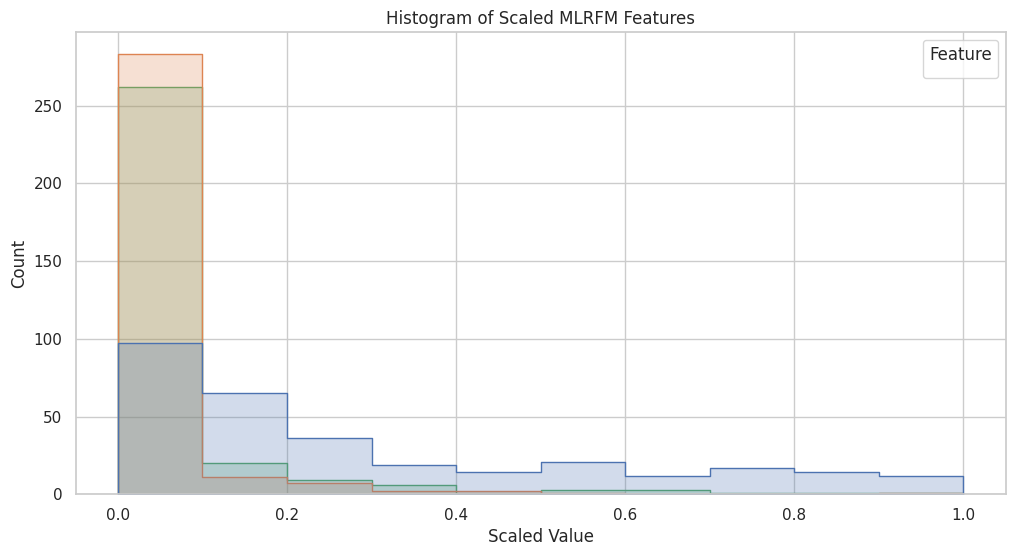

In [ ]:
# style
sns.set(style='whitegrid')

# Plot histogram for each feature
features = [ 'Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']

mlrfm_long = mlrfm_scaled_df[features].melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.histplot(data=mlrfm_long, x='Value', hue='Feature', element='step', common_norm=False, bins=10)
plt.title('Histogram of Scaled MLRFM Features')
plt.xlabel('Scaled Value')
plt.ylabel('Count')
plt.legend(title='Feature')
plt.show()

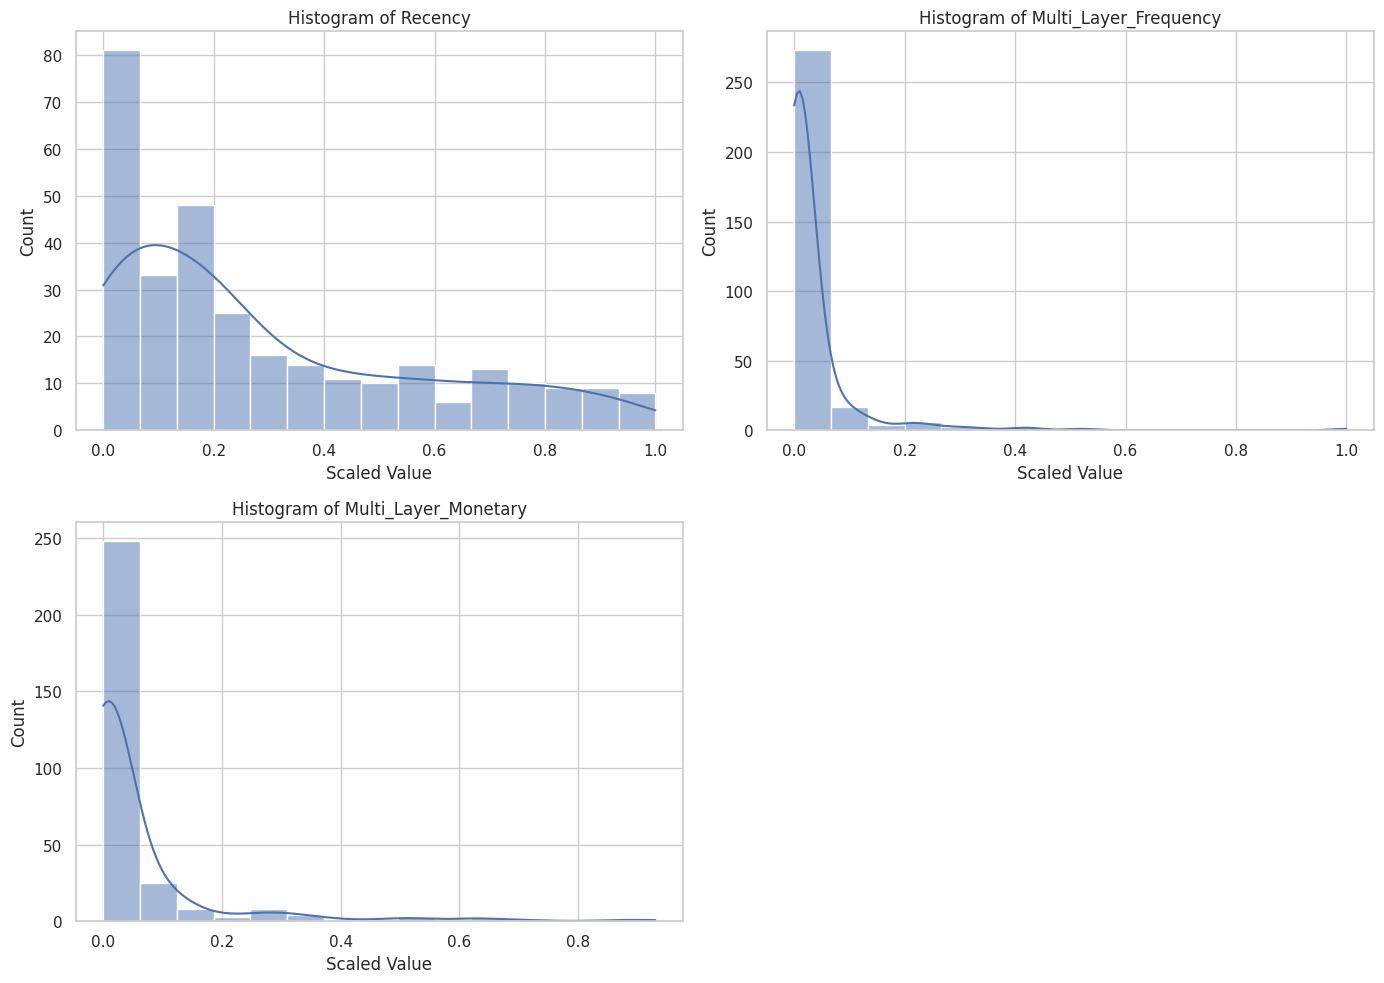

In [ ]:
features = [ 'Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']

plt.figure(figsize=(14, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(mlrfm_scaled_df[feature], bins=15, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
features = [ 'Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']

mlrfm_scaled_df[features].describe()

,Recency,Multi_Layer_Frequency,Multi_Layer_Monetary
count,307.000000,307.000000,307.000000
mean,0.294563,0.032039,0.054494
std,0.282612,0.085435,0.130624
min,0.000000,0.000000,0.000000
25%,0.053953,0.003187,0.001373
50%,0.189767,0.007521,0.006319
75%,0.473488,0.021774,0.036307
max,1.000000,1.000000,0.930001


yeo johnson transform

In [ ]:
customer_mlrfm_yeojohnson = final_mlrfm.copy()
cols_to_transform_mlrfm = [
    'Recency',
    'Frequency_365d', 'Monetary_365d',
    'Frequency_730d', 'Monetary_730d',
    'Frequency_1095d', 'Monetary_1095d'
]

pt = PowerTransformer(method='yeo-johnson')
transformed_values = pt.fit_transform(customer_mlrfm_yeojohnson[cols_to_transform_mlrfm])

customer_mlrfm_transformed = pd.DataFrame(
    transformed_values,
    columns=cols_to_transform_mlrfm
)

mlrfm_scaled_values = scaler.fit_transform(customer_mlrfm_transformed)

mlrfm_scaled_df_2 = pd.DataFrame(
    mlrfm_scaled_values,
    columns=cols_to_transform_mlrfm
)

mlrfm_scaled_df_2.insert(0, 'nama_customer', final_mlrfm['nama_customer'])
mlrfm_scaled_df_2.head()

,nama_customer,Recency,Frequency_365d,Monetary_365d,Frequency_730d,Monetary_730d,Frequency_1095d,Monetary_1095d
0,7 JAYA,0.300407,0.332340,0.766277,0.283250,0.616770,0.216192,0.656638
1,ANTO,0.306086,0.783950,0.899088,0.883354,0.846681,0.876505,0.850491
2,BELU ONE,0.590945,0.560208,0.728034,0.692864,0.607873,0.634354,0.641152
3,BERKAT UTAMA,0.306086,0.783950,0.816662,0.785085,0.706982,0.797511,0.751418
4,BINA MAKMUR,0.251093,0.332340,0.475094,0.283250,0.311943,0.000000,0.198508


<ipython-input-49-e926ca556fbb>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Feature')


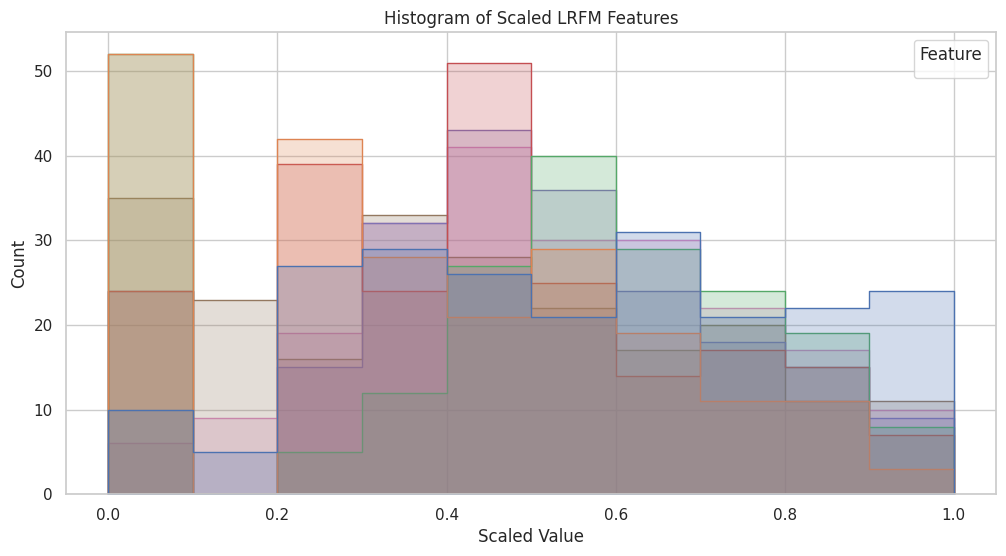

In [ ]:
# style
sns.set(style='whitegrid')

# Plot histogram for each feature
mlrfm_melted = mlrfm_scaled_df_2.melt(id_vars='nama_customer', var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.histplot(data=mlrfm_melted, x='Value', hue='Feature', element='step', common_norm=False, bins=10)
plt.title('Histogram of Scaled LRFM Features')
plt.xlabel('Scaled Value')
plt.ylabel('Count')
plt.legend(title='Feature')
plt.show()

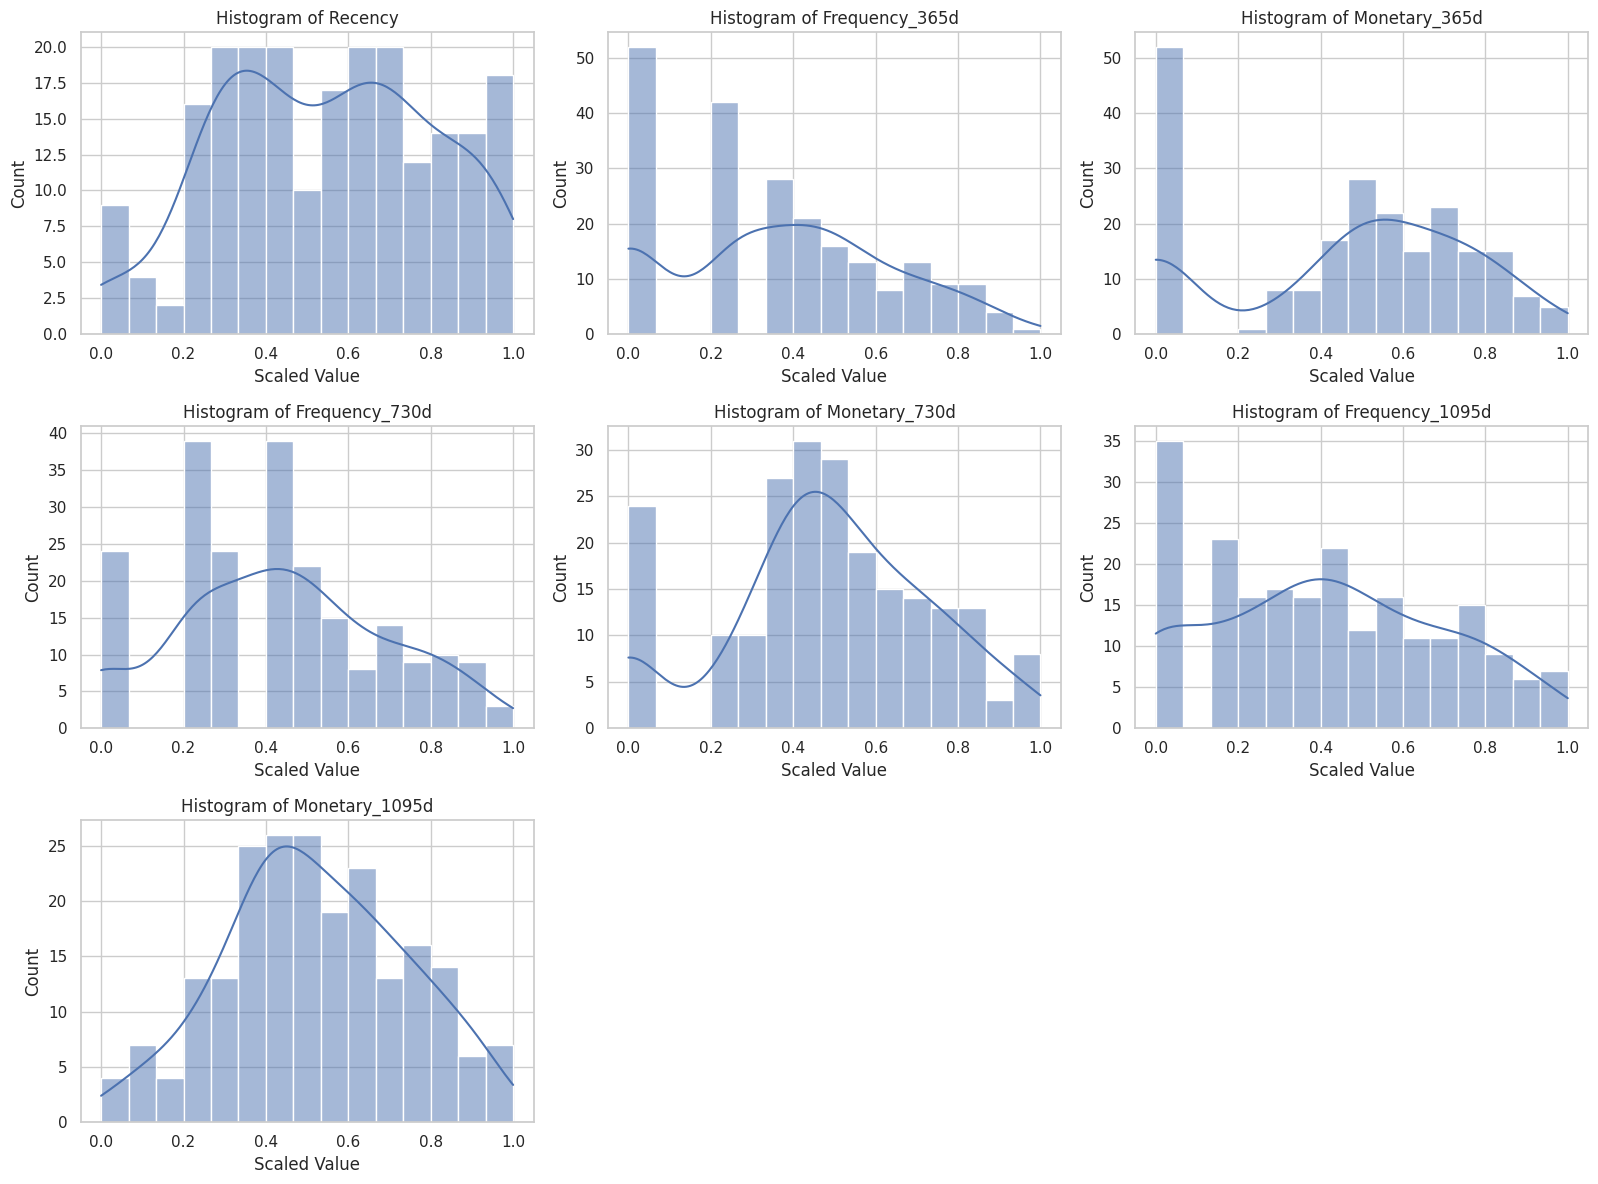

In [ ]:
mlrfm_features = ['Recency', 'Frequency_365d', 'Monetary_365d', 'Frequency_730d', 'Monetary_730d', 'Frequency_1095d', 'Monetary_1095d']

plt.figure(figsize=(16, 12))

for i, feature in enumerate(mlrfm_features, 1):
    plt.subplot(3, 3, i)  # enough room for 7 plots
    sns.histplot(mlrfm_scaled_df_2[feature], bins=15, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Final MLRFM

In [ ]:
# Create combined Frequency column
mlrfm_scaled_df_2['Multi_Layer_Frequency'] = (
    0.5 * mlrfm_scaled_df_2['Frequency_365d'] +
    0.3 * mlrfm_scaled_df_2['Frequency_730d'] +
    0.2 * mlrfm_scaled_df_2['Frequency_1095d']
)

# Create combined Monetary column
mlrfm_scaled_df_2['Multi_Layer_Monetary'] = (
    0.5 * mlrfm_scaled_df_2['Monetary_365d'] +
    0.3 * mlrfm_scaled_df_2['Monetary_730d'] +
    0.2 * mlrfm_scaled_df_2['Monetary_1095d']
)

# Check the new columns
print(mlrfm_scaled_df_2[['nama_customer', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']].head())


  nama_customer  Multi_Layer_Frequency  Multi_Layer_Monetary
0        7 JAYA               0.294383              0.699497
1          ANTO               0.832282              0.873647
2      BELU ONE               0.614834              0.674609
3  BERKAT UTAMA               0.787003              0.770709
4   BINA MAKMUR               0.251145              0.370832


In [ ]:
MLRFM_df = mlrfm_scaled_df_2[['nama_customer', 'Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']]
print(MLRFM_df.head())

  nama_customer   Recency  Multi_Layer_Frequency  Multi_Layer_Monetary
0        7 JAYA  0.300407               0.294383              0.699497
1          ANTO  0.306086               0.832282              0.873647
2      BELU ONE  0.590945               0.614834              0.674609
3  BERKAT UTAMA  0.306086               0.787003              0.770709
4   BINA MAKMUR  0.251093               0.251145              0.370832


plot

<ipython-input-67-a27cd07147ed>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Feature')


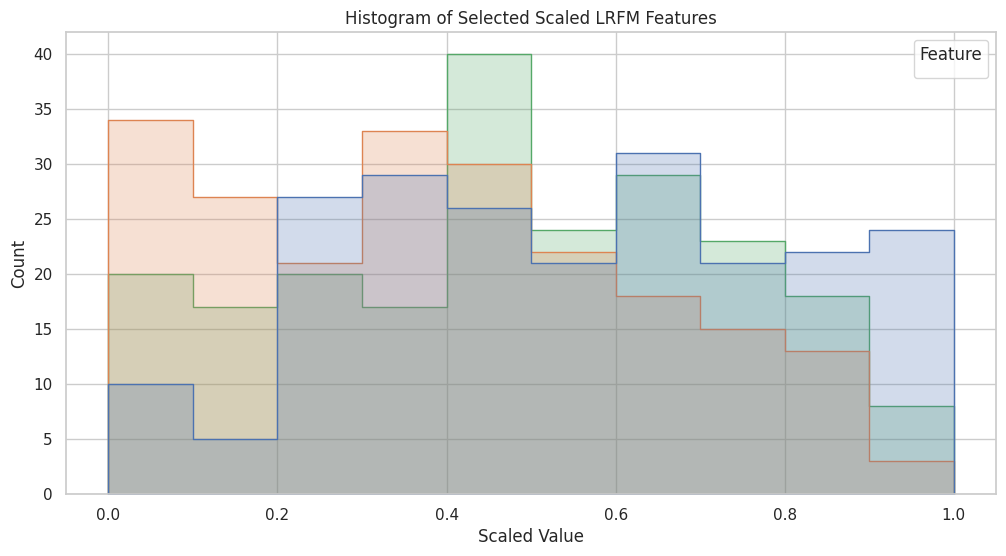

In [ ]:
# Set style
sns.set(style='whitegrid')

# Select columns to plot
features_to_plot = ['Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']

# Melt the dataframe for plotting
mlrfm_melted = MLRFM_df.melt(id_vars='nama_customer',
                                      value_vars=features_to_plot,
                                      var_name='Feature',
                                      value_name='Value')

plt.figure(figsize=(12, 6))
sns.histplot(data=mlrfm_melted,
             x='Value',
             hue='Feature',
             element='step',
             common_norm=False,
             bins=10)
plt.title('Histogram of Selected Scaled LRFM Features')
plt.xlabel('Scaled Value')
plt.ylabel('Count')
plt.legend(title='Feature')
plt.show()

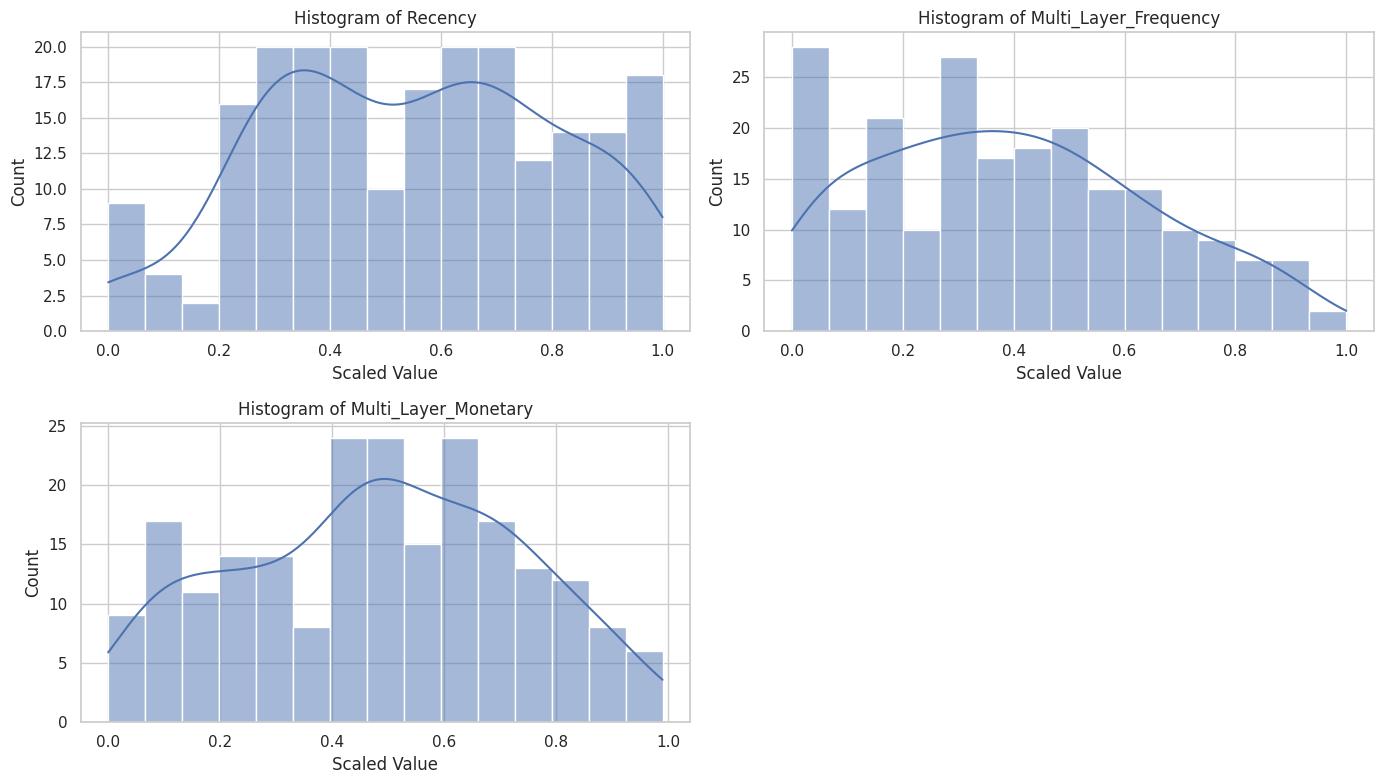

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']

plt.figure(figsize=(14, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(MLRFM_df[feature], bins=15, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
features = [ 'Recency', 'Multi_Layer_Frequency', 'Multi_Layer_Monetary']

MLRFM_df[features].describe()

,Recency,Multi_Layer_Frequency,Multi_Layer_Monetary
count,307.000000,307.000000,307.000000
mean,0.550455,0.373489,0.461977
std,0.265047,0.271698,0.257325
min,0.000000,0.000000,0.000000
25%,0.334162,0.129811,0.221896
50%,0.550971,0.294383,0.498620
75%,0.769802,0.588719,0.669693
max,1.000000,1.000000,0.992426


normalisasi MLRFM

In [ ]:
bins = [0.0, 0.10, 0.30, 0.50, 0.70, 1.0]
labels = [5, 4, 3, 2, 1]

cols_to_categorize = [
   'Recency',
   'Multi_Layer_Frequency',
   'Multi_Layer_Monetary'
]

Final_MLRFM_df = MLRFM_df.copy()

#binning
for col in cols_to_categorize:
    Final_MLRFM_df.loc[:, col + '_norm'] = pd.cut(Final_MLRFM_df[col], bins=bins, labels=labels, include_lowest=True)

print(Final_MLRFM_df.head())

  nama_customer   Recency  Multi_Layer_Frequency  Multi_Layer_Monetary  \
0        7 JAYA  0.398354               0.224384              0.642278   
1          ANTO  0.404459               0.749324              0.843621   
2      BELU ONE  0.677712               0.509670              0.613270   
3  BERKAT UTAMA  0.404459               0.692171              0.722770   
4   BINA MAKMUR  0.343869               0.193092              0.303150   

  Recency_norm Multi_Layer_Frequency_norm Multi_Layer_Monetary_norm  
0            3                          4                         2  
1            3                          1                         1  
2            2                          2                         2  
3            3                          2                         1  
4            3                          4                         3  


final MLRFM variable

In [ ]:
Result_MLRFM_df = Final_MLRFM_df.loc[:, ['nama_customer'] + [col for col in  Final_MLRFM_df.columns if col.endswith('_norm')]]

In [ ]:
print(Result_MLRFM_df.head())

  nama_customer Recency_norm Multi_Layer_Frequency_norm  \
0        7 JAYA            3                          4   
1          ANTO            3                          1   
2      BELU ONE            2                          2   
3  BERKAT UTAMA            3                          2   
4   BINA MAKMUR            3                          4   

  Multi_Layer_Monetary_norm  
0                         2  
1                         1  
2                         2  
3                         1  
4                         3  
